# Testing AudioMPS class

In [1]:
import sys
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

sys.path.append("../")

from model import RhoCMPS

In [2]:
sess = tf.InteractiveSession()

## Load Data

In [3]:
BATCH_SIZE = 32

In [4]:
guitar_dataset = tf.data.TFRecordDataset('../data/guitar.tfrecords')

In [5]:
parse_function = lambda example_proto: tf.parse_single_example(example_proto,
                                                               {"audio": tf.FixedLenFeature([2**16], dtype=tf.float32)})

In [6]:
guitar_dataset = guitar_dataset.map(parse_function)  # Parse the record into tensors.

In [7]:
guitar_dataset

<DatasetV1Adapter shapes: {audio: (65536,)}, types: {audio: tf.float32}>

In [8]:
guitar_dataset = guitar_dataset.batch(batch_size=BATCH_SIZE).shuffle(buffer_size=100).repeat()
guitar_iterator = guitar_dataset.make_one_shot_iterator()
guitar_batch = guitar_iterator.get_next()

In [18]:
guitar_batch['audio']

In [19]:
first_signal = (guitar_batch['audio'][0]).eval()

An example waveform

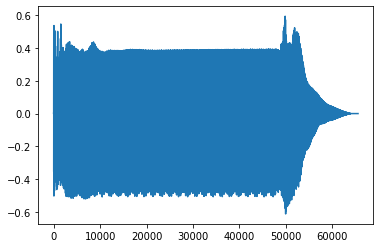

In [20]:
plt.plot(first_signal)

Close up

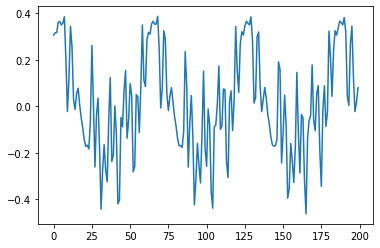

In [21]:
plt.plot(first_signal[20000:20200])

Here's the derivative

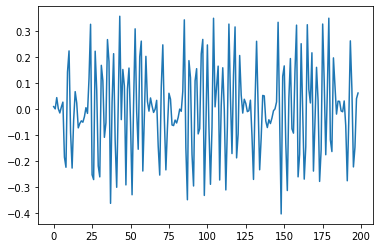

In [22]:
plt.plot(np.diff(first_signal[20000:20200]))

## Checking the loss works

In [23]:
BOND_D = 5

In [24]:
with tf.variable_scope("guitar_model"):
    guitar_model = AudioMPS(BOND_D, delta_t=0.01, data_iterator=guitar_batch['audio'])

NameError: name 'AudioMPS' is not defined

In [15]:
sess.run(tf.global_variables_initializer())

In [16]:
sess.run(guitar_model.loss)

NameError: name 'guitar_model' is not defined

## Training

### Damped sine wave with random time delay

In [ ]:
tf.sign?

In [ ]:
delays = tf.random_gamma([BATCH_SIZE], alpha=1, beta=None)

In [ ]:
input_length = 2**12
BATCH_SIZE = 8
RANDOM_DELAY = True
freq = 0.05
decay_time = input_length / 4
delay_time = input_length / 400

with tf.variable_scope("sine_model_data", reuse=tf.AUTO_REUSE):
    delays = tf.stack(INPUT_LENGTH * [tf.random_gamma([BATCH_SIZE], alpha=2, beta=2/delay_time)], axis=-1)
    
    input_range = tf.expand_dims(tf.range(INPUT_LENGTH,dtype=np.float32), axis=0)
    times = input_range - delays
    sine_wave_random_delay = 0.5 * (tf.sign(times) + 1) * tf.sin(2 * np.pi * freq * times) * tf.exp(-times/decay_time)
    
    
    
    

In [ ]:
for wave in sess.run(sine_wave_random_delay):
    plt.plot(wave[:40])

In [ ]:
BOND_D = 5
with tf.variable_scope("sine_model", reuse=tf.AUTO_REUSE):
    sine_model = AudioMPS(BOND_D, delta_t=0.01, data_iterator=sine_wave_random_phase)

Try training with the TF training script... does everything for us.

First add some summaries that we will track during training

In [ ]:
tf.summary.scalar("loss_function", tf.reshape(sine_model.loss, []))
tf.summary.audio("sample_inputs", sine_wave_random_phase, sample_rate=16000, max_outputs=1)

In [ ]:
step = tf.get_variable("global_step", [], tf.int64, tf.zeros_initializer(), trainable=False)
train_op = tf.train.AdamOptimizer(1e-3).minimize(sine_model.loss, global_step=step)

In [ ]:
tf.contrib.training.train(train_op, logdir="../logging", save_checkpoint_secs=60)

## Sampling 

Load the trained model into the current session.

In [ ]:
BOND_D = 5
with tf.variable_scope("sine_model", reuse=tf.AUTO_REUSE):
    sample_sine = AudioMPS(BOND_D, delta_t=0.01)

In [ ]:
ckpt_state = tf.train.get_checkpoint_state("../logging/")

In [ ]:
saver = tf.train.Saver()
saver.restore(sess, ckpt_state.model_checkpoint_path)

In [ ]:
samples = sample_sine.sample(5,1000,temp=0.000001)

In [ ]:
for sample in sess.run(samples):
    plt.plot(sample)